# 목차
1. 분석 방향
2. 데이터 Overview
3. 데이터 전처리

---------------
# 1. 분석 방향


카테고리마다 원하는 제품 설명(’name’,’brand’,’item_description’) 방식이 있고, 그 설명이 가격과 연결될 것이다.

## 제안
1. 가격에 따라 판매에 걸릴 시간에 대한 확률 제공 -- 시간 데이터가 없어서 알기 힘듦
2. 팔고자 하는 제품의 가격을 제안하는 서비스(진품명품 같은?)
3. 현재 트렌드랑의 상관관계?
4. 가격이 포함되어 있으면 rm이라고 나왔다고 하는데, 그러면 가격(rm)이 붙은 이름은 어떤 상관관계를 보일까
5. 부담을 누가하냐? if 판매자 : 가격에 배송비 o / elif 구매자 : 가격에 배송비 x --> 플랫폼 수수료(약 10%)가 있으니, 플랫폼 운영자 입장에서는 판매자가 부담하는 게 더 좋다. --> 판매자 부담하면서, 다양한 배송 옵션을 제공해주면?
6. 적절한 카테고리를 지정해주는게 가격에 영향이 있을까? --> 이름과 카테고리의 공통점이 있다면 더 잘 팔리지 않을까? or 이름에 카테고리에 포함된 게 있으면 자동으로 분류?
7. 카테고리가 세분화될수록 가격이 높아질까?
8. 카테고리, 브랜드, 아이템 설명에 결측치가 있는데, 복원하고 결측 여부에 대한 새로운 컬럼을 만들기
9. 제목에 다양한 정보가 포함되어 있으면 가격을 높게 받을 수 있을까?

## 접근 방향

1. 카테고리, 브랜드의 결측 여부를 표시하는 피쳐를 새롭게 생성한다.
2. train, test 데이터를 활용(같은 이름을 찾아서)하여 결측치를 최대한 입력한다.
3. train, test의 NLP 분류 모델을 사용하여 독립변수(상품명)을 이용하여 종속변수(브랜드)를 학습시키고 결측치를 입력한다.

--------------
# 2. 데이터 Overveiw

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import re

In [2]:
mercari_df=pd.read_csv('train.tsv',sep='\t')
test_df=pd.read_csv('test_stg2.tsv',sep='\t')

In [3]:
mercari_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [5]:
mercari_df.describe(include='all')

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1.482535e+06,1482535,1.482535e+06,1476208,849853,1.482535e+06,1.482535e+06,1482529
unique,NaN,1225273,NaN,1287,4809,NaN,NaN,1281425
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,NaN,No description yet
freq,NaN,2232,NaN,60177,54088,NaN,NaN,82489
mean,7.412670e+05,NaN,1.907380e+00,NaN,NaN,2.673752e+01,4.472744e-01,NaN
std,4.279711e+05,NaN,9.031586e-01,NaN,NaN,3.858607e+01,4.972124e-01,NaN
min,0.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,3.706335e+05,NaN,1.000000e+00,NaN,NaN,1.000000e+01,0.000000e+00,NaN
50%,7.412670e+05,NaN,2.000000e+00,NaN,NaN,1.700000e+01,0.000000e+00,NaN
75%,1.111900e+06,NaN,3.000000e+00,NaN,NaN,2.900000e+01,1.000000e+00,NaN


## 스키마 분석
### 속성
1. train_id : 거래 ID
2. name : 상품 이름
3. item_condition_id : 상품 상태(1 : 최상 ~ 5 : 최하)
    1. New (새 상품)
    2. Like New (거의 새 것)
    3. Good (좋음)
    4. Fair (보통)
    5. Poor (불량 또는 부품용)
5. category_name : 카테고리
6. brand_name : 브랜드
7. price : 판매 가격
8. shipping : 배송 주체
    + 0 : 구매자 부담
    + 1 : 판매자 부담
10. item_description : 제품 설명<br><br>
### 데이터 크기
    1482535 rows × 8 columns

--------
# 3. 데이터 전처리

## 중복 제거

In [6]:
# traind_id를 인덱스로
mercari_df=mercari_df.set_index('train_id')

In [7]:
# 중복 확인
print(mercari_df.duplicated().sum())
# 49개의 중복 데이터 발견
# 진짜 우연히 같은 걸까? 과적합 방지 drop?

49


In [8]:
mercari_df=mercari_df.drop_duplicates()

## 결측치 처리 

In [9]:
# 결측치 확인
mercari_df.isna().mean()*100
# 이걸 기입 안 해서 가격이 낮은 걸 수도 있으니, 결측 여부에 대한 새로운 피쳐 생성, 기입 가능한 정보는 기입하여 카테고리에 대한 분석 강화

name                  0.000000
item_condition_id     0.000000
category_name         0.426783
brand_name           42.674332
price                 0.000000
shipping              0.000000
item_description      0.000405
dtype: float64

### category_name, brand_name

In [10]:
# 안된 값은 가격에 그러한 영향이 있을 것이다.
mercari_df['no_cate']=mercari_df['category_name'].isna().astype(int)
mercari_df['no_brand']=mercari_df['brand_name'].isna().astype(int)

#### 같은 이름에서 찾기(train)

In [11]:
print(mercari_df.isna().sum())
# 중복되는 상품 이름 찾기
duplicated_name_train=mercari_df[mercari_df['name'].duplicated()]['name'].unique()

# 중복된 이름이면서 'category_name'이 nan값이 아닌 행들에서, 'name','category_name'만 추출, 하나의 이름만 남겨놓고 중복 제거, 이름을 인덱스로 설정, 'category_name'만 추출해서 Series로 반환
duplicated_category=mercari_df[(mercari_df['name'].isin(duplicated_name_train))&(mercari_df['category_name'].notna())][['name','category_name']].drop_duplicates(subset='name').set_index('name')['category_name']
# 'category_name'에서 결측값이 있는 행을 채운다, 어떤걸로? 반환된 시리즈를 결측치가 있는 mercari_df['name']을 키 값으로 찾아서
mercari_df['category_name']=mercari_df['category_name'].fillna(mercari_df['name'].map(duplicated_category))

# 위와 같은 작업, brand_name
duplicated_brand=mercari_df[(mercari_df['name'].isin(duplicated_name_train))&(mercari_df['brand_name'].notna())][['name','brand_name']].drop_duplicates(subset='name').set_index('name')['brand_name']
mercari_df['brand_name']=mercari_df['brand_name'].fillna(mercari_df['name'].map(duplicated_brand))

print(mercari_df.isna().sum())
# 브랜드 : 1203개 결측치 제거
# 카테고리 : 63773개 결측치 제거
# 이렇게 해도 안 되는 건 결측치 처리

name                      0
item_condition_id         0
category_name          6327
brand_name           632641
price                     0
shipping                  0
item_description          6
no_cate                   0
no_brand                  0
dtype: int64
name                      0
item_condition_id         0
category_name          5124
brand_name           568869
price                     0
shipping                  0
item_description          6
no_cate                   0
no_brand                  0
dtype: int64


#### 같은 이름에서 찾기(test)

In [12]:
# 겹치는 상품 이름 찾기
duplicated_name_test=test_df['name'].unique()

duplicated_category=test_df[(test_df['name'].isin(duplicated_name_test))&(test_df['category_name'].notna())][['name','category_name']].drop_duplicates(subset='name').set_index('name')['category_name']
mercari_df['category_name']=mercari_df['category_name'].fillna(mercari_df['name'].map(duplicated_category))

# 위와 같은 작업, brand_name
duplicated_brand=test_df[(test_df['name'].isin(duplicated_name_test))&(test_df['brand_name'].notna())][['name','brand_name']].drop_duplicates(subset='name').set_index('name')['brand_name']
mercari_df['brand_name']=mercari_df['brand_name'].fillna(mercari_df['name'].map(duplicated_brand))

mercari_df.isna().sum()

name                      0
item_condition_id         0
category_name          4718
brand_name           542304
price                     0
shipping                  0
item_description          6
no_cate                   0
no_brand                  0
dtype: int64

In [13]:
mercari_df=mercari_df.dropna(subset='category_name')
# 찾고 나서 없는 것은 제거

### item_description

In [14]:
mercari_df['item_description']=mercari_df['item_description'].fillna('No description yet')
print(len(mercari_df[mercari_df['item_description']=='No description yet']))
mercari_df['no_desc']=mercari_df['item_description']=='No description yet'

82060


## 데이터 변환
### 형식 변환

#### name, category_name, brand_name, item_description

In [15]:
mercari_df[['name','category_name','brand_name','item_description']] = mercari_df[['name','category_name','brand_name','item_description']].astype('string')
# mercari_df['name'] = mercari_df['name'].str.replace(r'[^0-9a-zA-Z\s]', '', regex=True).str.lower()

### 파생변수

#### name

##### 특수기호 사용 개수(영어, 숫자, 공백 이외)

In [16]:
mercari_df['name_special'] = mercari_df['name'].str.contains(r"[^A-Za-z\s]", regex=True)
mercari_df['name_special_count'] = mercari_df['name'].str.count(r"[^A-Za-z\s]")
special_list=[]
# for i in mercari_df['name'].str.findall(r"[^A-Za-z\s\d]"):
#     special_list.extend(i)
# print(set(special_list))

##### 숫자 사용여부

In [17]:
mercari_df['name_digit'] = mercari_df['name'].str.contains(r'/d', regex=True)
mercari_df['name_digit_count'] = mercari_df['name'].str.count(r"\d")

##### 가격 표시 여부

In [18]:
mercari_df['contains_rm'] = mercari_df['name'].str.contains('[rm]', regex=False)

#### category_name(보류 1개)

##### 카테고리 분리 및 카운트

In [19]:
# 어절로 구분해야할까 글자 수로 구분해야할까?
sep_category=mercari_df['category_name'].str.split('/',expand=True)
sep_category.columns=['cate1','cate2','cate3','cate4','cate5']
sep_category['category_count']=sep_category.count(axis=1)
sep_category.head()

,cate1,cate2,cate3,cate4,cate5,category_count
train_id,,,,,,
0,Men,Tops,T-shirts,<NA>,<NA>,3
1,Electronics,Computers & Tablets,Components & Parts,<NA>,<NA>,3
2,Women,Tops & Blouses,Blouse,<NA>,<NA>,3
3,Home,Home Décor,Home Décor Accents,<NA>,<NA>,3
4,Women,Jewelry,Necklaces,<NA>,<NA>,3


In [20]:
print
print(f'1번 분류 : {sep_category['cate1'].nunique()}')
print(f'2번 분류 : {sep_category['cate2'].nunique()}')
print(f'3번 분류 : {sep_category['cate3'].nunique()}')
print(f'4번 분류 : {sep_category['cate4'].nunique()}')
print(f'5번 분류 : {sep_category['cate5'].nunique()}')

1번 분류 : 10
2번 분류 : 113
3번 분류 : 870
4번 분류 : 6
5번 분류 : 2


In [21]:
sep_category['category_count'].value_counts().sort_index()
# 3번 이후의 값은 의미가 없나? 그래도 정밀한 비교를 위해서 남겨놓기로
# 1: 대분류, 2: 중분류, 3: 소분류

category_count
3    1473378
4       1331
5       3059
Name: count, dtype: int64

##### 이름에서 카테고리 찾기(보류)

In [22]:
# '/'와 '&' 기준으로 분리하고 그 값이 이름에도 포함되어있는지 판단하려고 함.
list_category=[]
for i in mercari_df['category_name'].str.split(r'[/&]', regex=True):
    list_category.extend(i)
sr_category=pd.Series(list_category)

sr_category=sr_category.str.lower().str.strip()

sr_category
# é와 같은 영어가 아닌 값도 포함되어있음

0                          men
1                         tops
2                     t-shirts
3                  electronics
4                    computers
                  ...         
5065180             home décor
5065181     home décor accents
5065182                  women
5065183    women's accessories
5065184                wallets
Length: 5065185, dtype: object

In [23]:
special_list=[]
for i in mercari_df['category_name'].str.findall(r"[^A-Za-z\s\d]"):
    special_list.extend(i)
print(set(special_list))
sr_category=sr_category.str.replace('é','e')

{'+', "'", 'é', '-', ',', ')', '(', '/', '&'}


In [24]:
mercari_df=pd.concat([mercari_df,sep_category],axis=1).drop('category_name',axis=1)

#### item_description

##### 설명 글자 수

In [25]:
# 설명의 길이가 가격의 영향
mercari_df['desc_len']=mercari_df['item_description'].str.replace('No description yet','').apply(len)

##### 설명 어절 수

In [26]:
#제목에 카테고리 or 브랜드와 매칭이 되는 정보가 있다?
mercari_df['desc_space']=mercari_df['item_description'].str.replace('No description yet','').str.split(r'\s').apply(len)

##### 가격 표시 여부

In [27]:
mercari_df['desc_rm'] = mercari_df['item_description'].str.contains('[rm]', regex=False)

In [28]:
mercari_df['desc_special'] = mercari_df['item_description'].str.contains(r"[^A-Za-z\s]", regex=True)
mercari_df['desc_special_count'] = mercari_df['item_description'].str.count(r"[^A-Za-z\s]")
special_list=[]
# for i in mercari_df['item_description'].str.findall(r"[^A-Za-z\s\d]"):
#     special_list.extend(i)
# print(set(special_list))

In [29]:
mercari_df['desc_digit'] = mercari_df['item_description'].str.contains(r'/d', regex=True)
mercari_df['desc_digit_count'] = mercari_df['item_description'].str.count(r"\d")

## TF-IDF

In [30]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower().strip()

mercari_df['clean_name'] = mercari_df['name'].apply(clean_text)
mercari_df['clean_desc'] = mercari_df['item_description'].apply(clean_text)
mercari_df['full_text'] = mercari_df['clean_name'] + " " + mercari_df['clean_desc']

### 대분류

In [32]:
category_keywords = []
unique_cate1 = mercari_df['cate1'].unique()

print(f"총 {len(unique_cate1)}개의 대분류(cate1) 분석 시작")

for cat in unique_cate1:
# (1) 데이터 필터링
    subset = mercari_df[mercari_df['cate1'] == cat]
    
    # 데이터가 100개 미만이면 학습/테스트 나누기에 너무 적으므로 패스
    if len(subset) < 100:
        continue

    # [속도 최적화] 데이터가 10,000개를 넘으면 랜덤 샘플링
    # 키워드 경향성 파악에는 1만 개면 통계적으로 충분합니다.
    if len(subset) > 20000:
        subset = subset.sample(n=20000, random_state=42)
        
    # (2) TF-IDF 벡터화
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000, min_df=10)
    
    try:
        # 이미 전처리된 'full_text' 컬럼을 사용한다고 가정
        X = tfidf.fit_transform(subset['full_text'])
    except ValueError:
        # 단어가 너무 없거나 비어있는 경우
        continue
        
    # (3) 타겟값 (로그 변환)
    y_log = np.log1p(subset['price'])
    
    # (4) Train / Test 분리 (8:2)
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    
    # (5) 릿지 회귀 학습 (Train 데이터로만!)
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    
    # (6) 모델 평가 (Test 데이터로 검증!)
    y_pred = model.predict(X_test)
    
    # 점수 계산
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # (7) 중요 단어 추출
    feature_names = tfidf.get_feature_names_out()
    coefs = model.coef_
    
    word_impact = pd.DataFrame({'word': feature_names, 'coef': coefs})
    
    top_pos = word_impact.sort_values(by='coef', ascending=False).head(10)
    top_neg = word_impact.sort_values(by='coef', ascending=True).head(10)
    
    # 결과 저장
    category_keywords.append({
        'Main_Category': cat,
        'Analyzed_Count': len(subset), # 샘플링된 개수 확인
        'R2_Score': round(r2, 3),
        'RMSE': round(rmse, 3),
        'Pos_Words': ", ".join(top_pos['word'].tolist()),
        'Neg_Words': ", ".join(top_neg['word'].tolist())
    })

# 2. 결과 출력 및 정렬
cate1_df = pd.DataFrame(category_keywords)

# R2 Score가 높은 순(신뢰도 높은 순)으로 정렬
cate1_df = cate1_df.sort_values(by='R2_Score', ascending=False)

print("\n분석 완료!")

총 10개의 대분류(cate1) 분석 시작

분석 완료!


In [33]:
cate1_df.head(10)

,Main_Category,Analyzed_Count,R2_Score,RMSE,Pos_Words,Neg_Words
1,Electronics,20000,0.524,0.658,"64gb, unlocked, 16gb, 32gb, gb, intel, nikon, ...","tracking, protectors, request, shower, protect..."
9,Handmade,20000,0.509,0.539,"virgin, kors, spade, extensions, mk, designer,...","sticker, nose, tracking, envelope, patch, deca..."
0,Men,20000,0.503,0.549,"gucci, deadstock, rolex, foamposite, 11s, move...","orders, socks, mask, tshirt, ring, shirt, earr..."
2,Women,20000,0.405,0.570,"14k, tiffany, vuitton, authentic, lululemon, k...","choker, tracking, piercing, read, mossimo, sav..."
4,Sports & Outdoors,20000,0.400,0.555,"blaze, hoverboard, surge, samsung, comes, alta...","save, sticker, replacement, stickers, decal, l..."
5,Vintage & Collectibles,20000,0.339,0.667,"speedy, 14k, kors, vuitton, 10k, lv, louis, co...","upper, person, yugioh, fleer, keychain, envelo..."
8,Kids,20000,0.306,0.558,"hatchimals, tula, burberry, cans, huge, 7y, ju...","discounts, slime, comment, save, keychain, tra..."
3,Home,20000,0.298,0.560,"mixing, vacuum, sherpa, rare, teapot, canister...","bts, sticker, number, silicone, tracking, deca..."
7,Other,20000,0.282,0.622,"shakeology, test, ti84, supply, 200, thrive, s...","tracking, envelope, stickers, recyclable, penc..."
6,Beauty,20000,0.281,0.529,"rodan, bundle, 34oz, iron, lipsense, chanel, f...","pocketbac, vary, sample, save, random, maybell..."


### 중분류

In [ ]:
'''
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(mercari_df['full_text'])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, mercari_df['price'], test_size=0.2, random_state=42)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE (평균 오차): {rmse:.2f}")
print(f"R² Score (설명력): {r2:.4f}")

feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_

word_impact = pd.DataFrame({
    'Word': feature_names,
    'Impact (Coefficient)': coefficients
}).sort_values(by='Impact (Coefficient)', ascending=False)

print("\n[가격에 긍정/부정적 영향을 미치는 단어 상위/하위]")
print(word_impact.head(3)) # 가격 상승 키워드
print(word_impact.tail(3)) # 가격 하락 키워드
'''

In [34]:
category_keywords = []
unique_cate2 = mercari_df['cate2'].unique()

print(f"총 {len(unique_cate2)}개의 중분류(cate2) 분석 시작")

for cat in unique_cate2:
# (1) 데이터 필터링
    subset = mercari_df[mercari_df['cate2'] == cat]
    
    # 데이터가 100개 미만이면 학습/테스트 나누기에 너무 적으므로 패스
    if len(subset) < 100:
        continue

    # [속도 최적화] 데이터가 10,000개를 넘으면 랜덤 샘플링
    # 키워드 경향성 파악에는 1만 개면 통계적으로 충분합니다.
    if len(subset) > 20000:
        subset = subset.sample(n=20000, random_state=42)
        
    # (2) TF-IDF 벡터화
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000, min_df=10)
    
    try:
        # 이미 전처리된 'full_text' 컬럼을 사용한다고 가정
        X = tfidf.fit_transform(subset['full_text'])
    except ValueError:
        # 단어가 너무 없거나 비어있는 경우
        continue
        
    # (3) 타겟값 (로그 변환)
    y_log = np.log1p(subset['price'])
    
    # (4) Train / Test 분리 (8:2)
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    
    # (5) 릿지 회귀 학습 (Train 데이터로만!)
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    
    # (6) 모델 평가 (Test 데이터로 검증!)
    y_pred = model.predict(X_test)
    
    # 점수 계산
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # (7) 중요 단어 추출
    feature_names = tfidf.get_feature_names_out()
    coefs = model.coef_
    
    word_impact = pd.DataFrame({'word': feature_names, 'coef': coefs})
    
    top_pos = word_impact.sort_values(by='coef', ascending=False).head(5)
    top_neg = word_impact.sort_values(by='coef', ascending=True).head(5)
    
    # 결과 저장
    category_keywords.append({
        'Main_Category': subset['cate1'].iloc[0],
        'Sub_Category': cat,
        'Analyzed_Count': len(subset), # 샘플링된 개수 확인
        'R2_Score': round(r2, 3),
        'RMSE': round(rmse, 3),
        'Pos_Words': ", ".join(top_pos['word'].tolist()),
        'Neg_Words': ", ".join(top_neg['word'].tolist())
    })

# 2. 결과 출력 및 정렬
cate2_df = pd.DataFrame(category_keywords)

# R2 Score가 높은 순(신뢰도 높은 순)으로 정렬
cate2_df = cate2_df.sort_values(by='R2_Score', ascending=False)

print("\n분석 완료!")

총 113개의 중분류(cate2) 분석 시작

분석 완료!


In [35]:
cate2_df.head(10)

,Main_Category,Sub_Category,Analyzed_Count,R2_Score,RMSE,Pos_Words,Neg_Words
16,Electronics,Cell Phones & Accessories,20000,0.637,0.562,"128gb, 64gb, 32gb, unlocked, 16gb","pokemon, nano, protectors, tracking, line"
50,Vintage & Collectibles,Accessories,8220,0.621,0.496,"bellami, cashmere, density, rayban, dyed","puffy, bundleable, patch, number, accessories"
54,Electronics,"TV, Audio & Surveillance",9131,0.611,0.570,"bose, ring, airpods, nest, ue","tracking, ipad, supports, isolating, mp4"
1,Electronics,Computers & Tablets,7440,0.600,0.704,"i5, i7, gtx, 2016, 2015","durable, fits, compatible, different, case"
4,Women,Jewelry,20000,0.568,0.615,"dy, yurman, tiffany, 14k, 10k","bags, tracking, envelope, profile, waste"
35,Kids,Boys (4+),14763,0.567,0.468,"foamposite, nmd, 12s, 11s, 11","socks, mouse, shirt, tshirt, underwear"
21,Women,Women's Handbags,20000,0.546,0.647,"mcm, gm, receipt, tory, mm","ipsy, save, shopping, deals, came"
51,Handmade,Bags and Purses,6347,0.537,0.697,"keepall, receipt, ysl, chanel, neverfull","flat, wristlet, coin, faux, getting"
90,Kids,Safety,401,0.521,0.621,"owlet, oxygen, monitor, socks, video","safety, child, dog, toddler, lock"
39,Men,Men's Accessories,18683,0.517,0.554,"cartier, rolex, private, movado, mcm","shademe, stickers, outdoor, save, remove"


# 보류

## 여러 번 등장한 name (위에서 사용 중)

In [36]:
# 중복되는 상품 찾기
duplicated_name=mercari_df[mercari_df['name'].duplicated()]['name'].unique()
print(duplicated_name)

<StringArray>
[                              'Bundle',
                                'Boots',
                        'Black booties',
                                'Dress',
                     'Pandora bracelet',
         'Giffin 25 rdta full tank kit',
                       'Tommy Hilfiger',
                      'Lululemon crops',
                    'Kate Spade Wallet',
                          'Urban decay',
 ...
                    'Metal mulisha top',
                           'Waist Belt',
  'Dallas Cowboys sport utility gloves',
           'Mary kay botanical effects',
                 'Ankle boots size 6.5',
                'Mac studio fix powder',
  'Jeffrey Star Velour Liquid Lipstick',
            'Victoria secret black bag',
 'New Bath & Body Works Scented Candle',
   'Tarte Amazonian clay 12 hour blush']
Length: 83222, dtype: string


In [37]:
# 컬럼 길이 넓히기
pd.set_option('display.max_colwidth',200)

In [38]:
mercari_df[mercari_df['name'].isin(duplicated_name)].sort_values('name')[['name','item_description']]
# 이름을 !!특가!! 이런식으로 써놓은 것도 있네

,name,item_description
train_id,,
408319,!!!Jewelry Sale!!! 3 days only! [rm],Retro Crystal Butterfly one Ear Cuff Stud Earring Wrap. NWT ( Gold)
966280,!!!Jewelry Sale!!! 3 days only! [rm],Retro Crystal Butterfly one Ear Cuff Stud Earring Wrap. NWT ( Silver)
871965,!!!Lingerie Sale!!! 3 Days only! [rm],Women Sexy Nightwear Black Strap & Bra Thongs Underwear Suit Sleepwear Lace Vest. Ex Small-size with Adjustable straps. NWT.
1081227,!!!Lingerie Sale!!! 3 Days only! [rm],Sexy Black and Brown Bra & Panties Set Hollow Butterfly Perspective Bra & G-string Underwear . NWT.
250695,!!SALE!! Faux fur Pom Pom Keychain NWT,"One Week SALE POM POM FIRM!! NO FREE SHIPPING! Light Gray Faux FurPom Pom Keychain NEW perfect for your purse, not Michael Kors but pretty on them ☺️"
...,...,...
375271,》XMAS SALE! NEW CLASSY SMART WATCH W/CAM,A1 Functions: Bluetooth: this smart watch can connect Smartphone by using Bluetooth Phonebook: the mobile phone contacts will be displayed in the machine when they connect. Dialer: watch is connec...
1370477,》free ship《 Usc tshirt,Usc Carolina gamecocks Carolina girl t shirt size small
789311,》free ship《 Usc tshirt,Usc Carolina gamecocks tshirt


# 그래프

In [39]:
mercari_df.columns

Index(['name', 'item_condition_id', 'brand_name', 'price', 'shipping',
       'item_description', 'no_cate', 'no_brand', 'no_desc', 'name_special',
       'name_special_count', 'name_digit', 'name_digit_count', 'contains_rm',
       'cate1', 'cate2', 'cate3', 'cate4', 'cate5', 'category_count',
       'desc_len', 'desc_space', 'desc_rm', 'desc_special',
       'desc_special_count', 'desc_digit', 'desc_digit_count', 'clean_name',
       'clean_desc', 'full_text'],
      dtype='object')

In [40]:
mercari_df=mercari_df[['price','name', 'item_condition_id', 'brand_name', 'shipping',
       'item_description', 'no_cate', 'no_brand', 'no_desc', 'name_special',
       'name_special_count', 'name_digit', 'name_digit_count', 'contains_rm',
       'cate1', 'cate2', 'cate3', 'cate4', 'cate5', 'category_count',
       'desc_len', 'desc_space', 'desc_rm', 'desc_special',
       'desc_special_count', 'desc_digit', 'desc_digit_count']]
mercari_df.columns=['가격','이름','제품 상태','브랜드','배송 판매자 부담','제품 설명','카테고리 결측','브랜드 결측','설명 결측','이름 특수기호','이름 특수기호 개수','이름 숫자','이름 숫자 개수','이름 가격','대분류','중분류','소분류','소소분류','소소소분류','카테고리 수','설명 글자 수','설명 어절 수','설명 가격','설명 특수기호','설명 특수기호 개수','설명 숫자','설명 숫자 개수']

## 기본 그래프

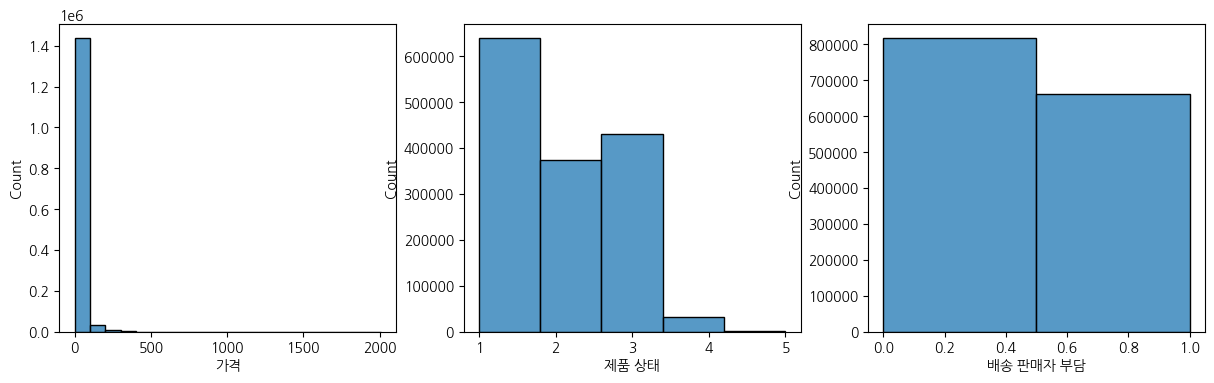

In [41]:
plt.figure(figsize=(20,4))
plt.subplot(141)
sns.histplot(mercari_df,x='가격',bins=20)
plt.subplot(142)
sns.histplot(mercari_df,x='제품 상태',bins=5)
plt.subplot(143)
sns.histplot(mercari_df,x='배송 판매자 부담',bins=2)
plt.show()

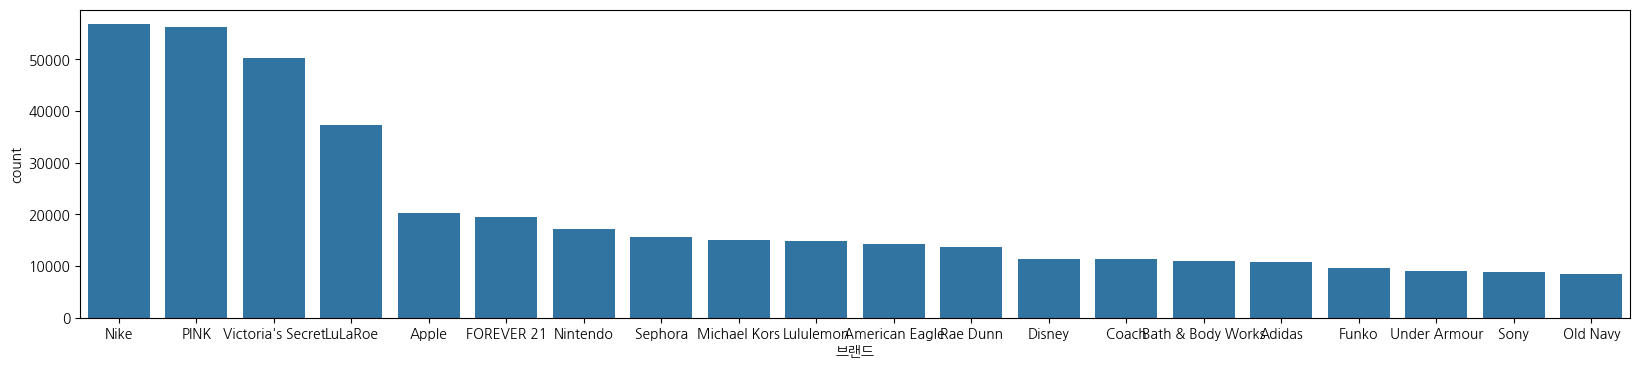

In [42]:
plt.figure(figsize=(20,4))
a=mercari_df['브랜드'].value_counts().head(20).reset_index()
sns.barplot(x=a['브랜드'],y=a['count'])
plt.show()

## 대분류 카테고리별

대분류
Women                     45.01
Beauty                    14.07
Kids                      11.63
Electronics                8.31
Men                        6.35
Home                        4.6
Vintage & Collectibles     3.15
Other                      3.08
Handmade                   2.09
Sports & Outdoors          1.72
Name: proportion, dtype: Float64


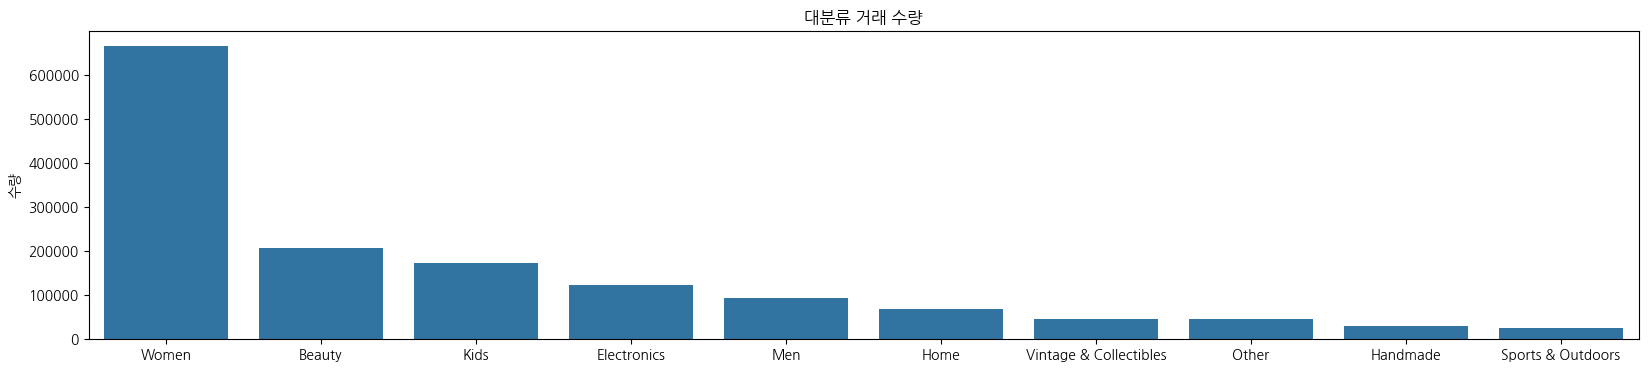

In [43]:
print(round(mercari_df['대분류'].value_counts(normalize=True)*100,2).sort_values(ascending=False))
plt.figure(figsize=(20,4))
sns.countplot(data=mercari_df, x='대분류',order=mercari_df['대분류'].value_counts().index)
plt.title('대분류 카테고리')
plt.xlabel('')
plt.ylabel('수량')
plt.title('대분류 거래 수량')
plt.show()

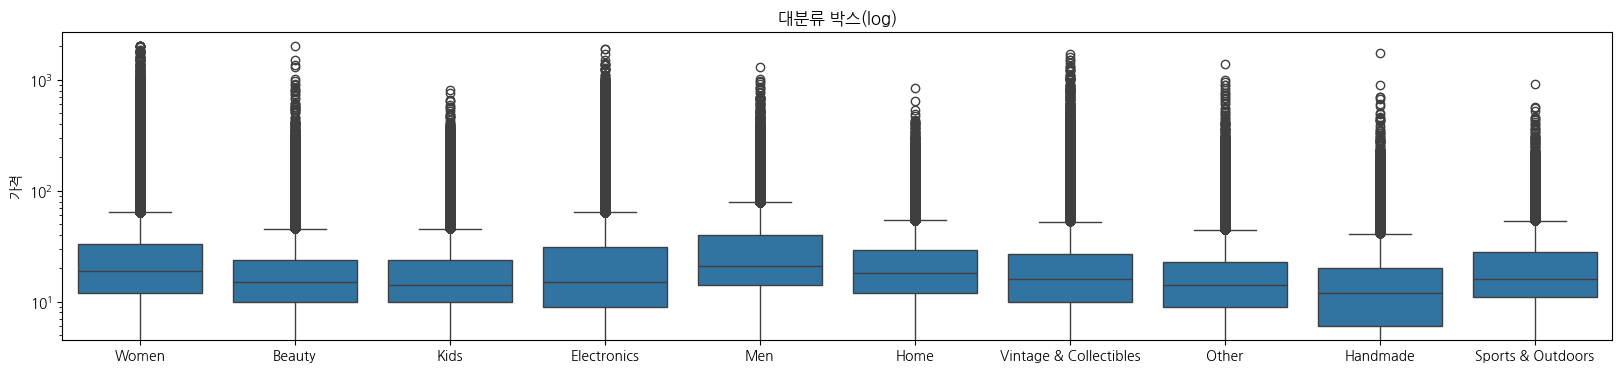

In [44]:
plt.figure(figsize=(20,4))
sns.boxplot(mercari_df, x='대분류', y='가격',order=mercari_df['대분류'].value_counts().index)
plt.yscale('log')
plt.xlabel('')
plt.title('대분류 박스(log)')
plt.show()

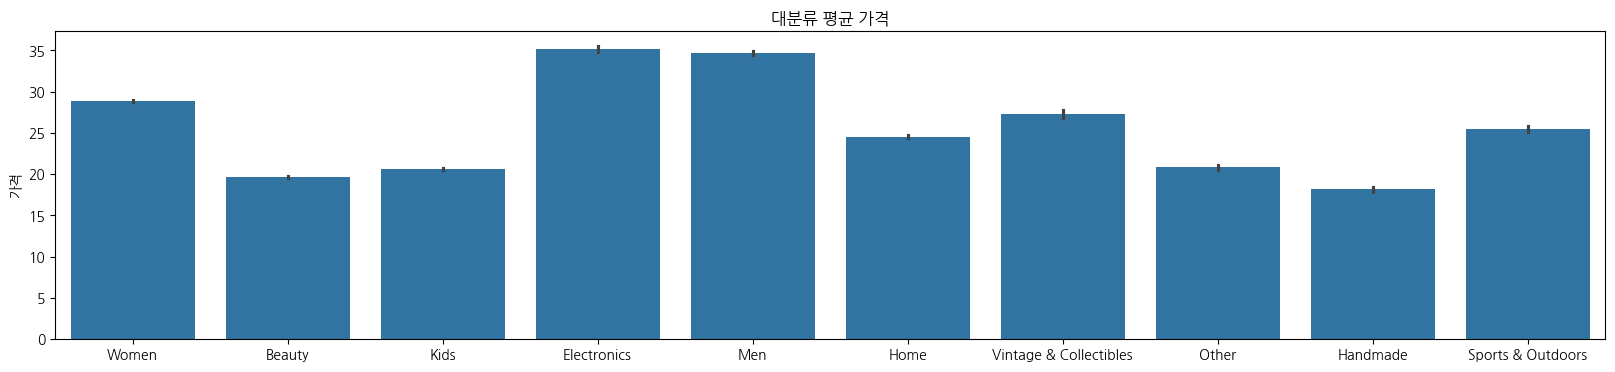

In [45]:
plt.figure(figsize=(20,4))
sns.barplot(mercari_df, x='대분류', y='가격',order=mercari_df['대분류'].value_counts().index)
plt.title('대분류 평균 가격')
plt.xlabel('')
plt.show()

In [46]:
corr_df = mercari_df.groupby('대분류').corr(numeric_only=True).unstack().reindex(['Women', 'Beauty', 'Kids', 'Electronics', 'Men', 'Home','Vintage & Collectibles', 'Other', 'Handmade', 'Sports & Outdoors'])
corr_df.iloc[:,0:12]

가격                                                    \
                         가격     제품 상태 배송 판매자 부담   카테고리 결측    브랜드 결측     설명 결측   
대분류                                                                             
Women                   1.0 -0.069643 -0.055053 -0.003079 -0.090068 -0.033931   
Beauty                  1.0 -0.014361 -0.151767  0.003588 -0.033442 -0.008947   
Kids                    1.0 -0.048369 -0.134073  0.005234 -0.077775 -0.029552   
Electronics             1.0  0.120542 -0.162674  0.002582 -0.253161 -0.058979   
Men                     1.0 -0.115006 -0.047635  0.003625 -0.131239 -0.035572   
Home                    1.0 -0.101502 -0.173526 -0.000901 -0.179512 -0.015815   
Vintage & Collectibles  1.0  0.043267 -0.102783 -0.001738 -0.087350 -0.032142   
Other                   1.0  0.021073 -0.140058  0.012397 -0.052470 -0.024420   
Handmade                1.0  0.126608 -0.213336 -0.006929  0.000785 -0.023422   
Sports & Outdoors       1.0  0.040160 -0.109164 -0.008933 -0.224197 -0.028112   

                                                                           \
                         이름 특수기호 이름 특수기호 개수     이름 숫자  이름 숫자 개수     이름 가격   
대분류                                                                         
Women                   0.014593   0.034715  0.001806  0.038668  0.010107   
Beauty                  0.021905   0.031681 -0.001226  0.033942 -0.015423   
Kids                    0.013200   0.031759 -0.000920  0.037464 -0.017235   
Electronics             0.077412   0.121983 -0.003068  0.169951 -0.015296   
Men                     0.107670   0.167356 -0.003686  0.231890 -0.004513   
Home                    0.040685   0.046852  0.005027  0.034783  0.009408   
Vintage & Collectibles -0.000457  -0.002715 -0.002827 -0.004545  0.016359   
Other                   0.004915  -0.006959 -0.003498 -0.013481  0.067007   
Handmade               -0.002288   0.032541 -0.005482  0.052148 -0.005939   
Sports & Outdoors       0.080685   0.105381  0.000145  0.115580 -0.009199   

                                  
                          카테고리 수  
대분류                               
Women                        NaN  
Beauty                       NaN  
Kids                         NaN  
Electronics             0.093858  
Men                     0.006340  
Home                         NaN  
Vintage & Collectibles       NaN  
Other                        NaN  
Handmade                0.009673  
Sports & Outdoors      -0.000296

### 상관관계 가이드라인
 + |r| < 0.1
상관 없음(Negligible)
 + 0.1 ≤ |r| < 0.3
매우 약한 상관(Very Weak)
 + 0.3 ≤ |r| < 0.5
약한 상관(Weak)
 + 0.5 ≤ |r| < 0.7
중간 정도의 상관(Moderate)
 + 0.7 ≤ |r| < 0.9
강한 상관(Strong)
 + |r| ≥ 0.9
매우 강한 상관(Very Strong)
### 기본 발견
1. 카테고리는 기본적으로 3가지를 입력하게 되어있다. (최소 3, 제품에 따라 최대 5) 따라서, 3가지를 각각 대분류, 중분류, 소분류로 사용 가능하다.
2. 카테고리에 따라 기본적인(평균) 가격대를 예상할 수 있다. -> 입력한 카테고리를 바탕으로 가격을 예측해주는 요소로 활용 가능

### 속성 발견
1. 제품 상태
   + [Electronics, Vintage & Collectibles, Other, Handmade, Sports & Outdoors]에서는 상품의 상태와 가격이 비례하지 않는다.
2. 배송 부담 주체
   + 모든 대분류에서 판매자가 부담을 했을 시, 가격이 감소됨을 확인할 수 있다.
4. 결측 여부
   + 카테고리에 대한 결측 여부는 대조할만한 값이 충분하지 않기 때문(1609개의 데이터밖에 존재하지 않음)에 상관관계를 입증하기 어렵다.
   + Handmade를 제외하고는 브랜드가 없을 시 가격이 하락한다. / Handmade는 브랜드가 없기 때문에 가격과 상관관계가 없다.
6. 이름에 포함된 요소
   + 특수기호, 숫자, 가격이 포함되었다고 하여 상관관계가 있다고 볼 수 없다.
8. 카테고리 수
   + 관계 없음
10. 제품 설명
    + 관계 없음

## 중분류 카테고리별

In [47]:
pd.set_option('display.max_rows',138)
a=mercari_df.groupby(['대분류','중분류'])['가격'].count().reset_index(name='count').sort_values('count',ascending=False).head(20)
a

,대분류,중분류,count
3,Beauty,Makeup,124704
121,Women,Athletic Apparel,123541
134,Women,Tops & Blouses,107073
129,Women,Shoes,77724
73,Kids,Toys,57770
125,Women,Jewelry,56899
9,Electronics,Cell Phones & Accessories,53300
137,Women,Women's Handbags,45934
123,Women,Dresses,45864
136,Women,Women's Accessories,42389


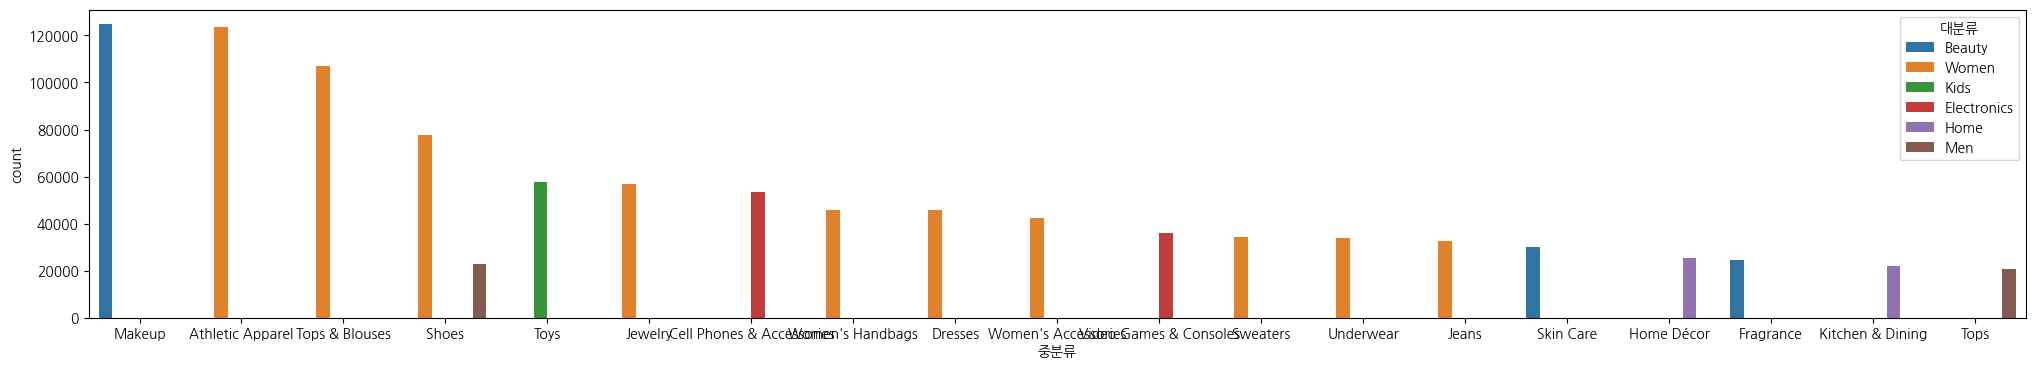

In [48]:
plt.figure(figsize=(25,4))
sns.barplot(a, x='중분류',y='count', hue='대분류')
plt.show()

In [49]:
corr_dict = {}

# 대분류 순서를 유지한 채로 생성
cate2_list = mercari_df[['대분류','중분류']].sort_values('대분류')['중분류'].drop_duplicates()
for i in cate2_list:
    subset = mercari_df[mercari_df['중분류'] == i]
    corr = subset.corr(numeric_only=True)['가격']   # 가격과의 상관만 추출
    corr_dict[i] = corr


corr_df = pd.DataFrame(corr_dict).T

In [50]:
corr_df.head()

,가격,제품 상태,배송 판매자 부담,카테고리 결측,브랜드 결측,설명 결측,이름 특수기호,이름 특수기호 개수,이름 숫자,이름 숫자 개수,이름 가격,카테고리 수,설명 글자 수,설명 어절 수,설명 가격,설명 특수기호,설명 특수기호 개수,설명 숫자,설명 숫자 개수
Makeup,1.0,-0.019562,-0.138360,0.004817,-0.081327,0.000172,0.001373,0.006281,-0.003319,0.007771,-0.012470,NaN,0.016727,0.013728,0.014667,0.008938,0.017514,0.002082,0.038522
Tools & Accessories,1.0,0.057971,-0.212873,-0.006089,-0.007023,-0.045233,-0.017559,0.003300,-0.004300,0.013258,-0.013166,NaN,0.039914,0.040555,0.108239,0.062682,0.044277,0.005183,0.077713
Bath & Body,1.0,-0.029067,-0.211745,0.007152,0.016250,0.004610,-0.006141,-0.020168,-0.001179,0.031636,-0.071033,NaN,0.013475,0.018663,-0.045850,0.039272,0.054868,-0.004528,0.144463
Hair Care,1.0,-0.077020,-0.162090,0.033131,0.066351,-0.008733,0.044451,0.088941,0.009493,0.106162,0.000017,NaN,0.067516,0.067929,0.083221,0.010865,0.107773,-0.014555,0.160729
Skin Care,1.0,-0.022059,-0.137294,0.000851,0.060576,-0.023230,0.035352,0.023016,0.005981,0.000302,-0.010547,NaN,-0.004204,-0.005850,0.085808,0.030374,0.021664,0.001716,0.057927


In [51]:
corr_df.columns

Index(['가격', '제품 상태', '배송 판매자 부담', '카테고리 결측', '브랜드 결측', '설명 결측', '이름 특수기호',
       '이름 특수기호 개수', '이름 숫자', '이름 숫자 개수', '이름 가격', '카테고리 수', '설명 글자 수',
       '설명 어절 수', '설명 가격', '설명 특수기호', '설명 특수기호 개수', '설명 숫자', '설명 숫자 개수'],
      dtype='object')

In [52]:
for i in ['제품 상태','배송 판매자 부담','카테고리 결측','브랜드 결측','설명 결측','이름 특수기호','이름 특수기호 개수','이름 숫자','이름 숫자 개수','이름 가격','카테고리 수','설명 글자 수','설명 어절 수','설명 가격','설명 특수기호','설명 특수기호 개수','설명 숫자','설명 숫자 개수']:
    print(f'\n속성 : {i}')
    print(corr_df[corr_df[i].apply(abs)>=0.2][i].sort_values(ascending=False))


속성 : 제품 상태
Cell Phones & Accessories    0.274144
Others                       0.260771
Office supplies              0.218493
Paper Goods                  0.215481
Pants                       -0.201049
Tops                        -0.222223
Shorts                      -0.229157
Athletic Apparel            -0.243710
Jeans                       -0.246681
Woodworking                 -0.252553
Tops & Blouses              -0.259956
Books and Zines             -0.271271
Ceramics and Pottery        -0.287048
Maternity                   -0.287494
Skirts                      -0.314138
Sweats & Hoodies            -0.321188
Potty Training              -0.348637
Sweaters                    -0.365922
Blazers & Sport Coats       -0.425975
Footwear                    -0.453183
Name: 제품 상태, dtype: float64

속성 : 배송 판매자 부담
Patterns                    -0.200738
Glass                       -0.201675
Crochet                     -0.201971
Pets                        -0.205868
Car Audio, Video & GPS      -0.2